# Clustering of Trajectories under Global Confounding -- Chen-Poor

In [1]:
import sys
# setting path
sys.path.append('../core')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"


from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

import dfply
from dfply import *
import ray
import datetime


import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy

from subspace import *
from clustering import *
from em import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

In [2]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]


horizon = 200 #18
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                    confound_weight=0.6, small=True, soft=True)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])



In [3]:
for mdp , pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in [envs[-1]]:
    
    print("---")
    
    print("running env with horizon", horizon)

    dataset = confound_mdp.collect_sample(int(100), mdp, pi_b, horizon, iid=False)
    data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
    Phat = confound_ope.estimate_P(dataset, mdp)
    pihat = confound_ope.estimate_pi(dataset, mdp)
    for a in range(nActions):
        for s in range(nStates):
            if Phat[a,s].sum() == 0:
                Phat[a,s,term] = 1
            if pihat[s].sum() == 0:
                pihat[s,:] = 1/nActions
    pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]

    # This is the actual reward_sa
    # P(s,a,s') * R(s,a,s')
    # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
    R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
    P_spsa = Phat.transpose((2, 1, 0))
    n = data.shape[0]


     # behavior value
    print("value of pi_b")
    returns = confound_mdp.calc_returns(dataset, gamma, horizon)
    print(returns.mean())

---
running env with horizon 200
value of pi_b
-1.8766839784966785


In [30]:
import multiprocessing
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import copy

nprocs = 10

with ProcessPoolExecutor(max_workers=nprocs, mp_context=multiprocessing.get_context('fork')) as executor:
    future = executor.map(confound_mdp.collect_sample, [int(10000/nprocs) for i in range(nprocs)], repeat(copy.deepcopy(mdp)), 
                          repeat(copy.deepcopy(pi_b)), repeat(horizon), repeat(False))
dataset = np.vstack(list(future))

In [32]:
np.vstack(datasets).shape

(10000, 200, 5)

In [112]:
from numba import njit
#Ptrue_spsa = np.einsum('u,uasp->psa', u_dist, P)
pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)
Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)

burnin = 10
N_sa = getN_sa(dataset, burnin=burnin)

NameError: name 'getN_sa' is not defined

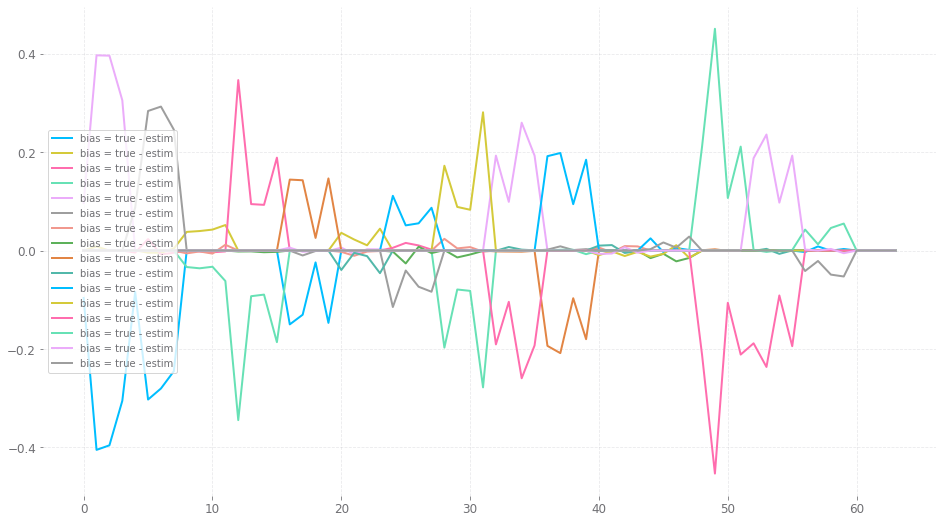

In [145]:
plt.figure(figsize=(16,9))
plt.plot((Pb_spsa - P_spsa).transpose(1,2,0).reshape(nStates*nActions, nStates), label='bias = true - estim')
plt.legend()

## Method 1: PCA >%> ToMATo Clustering >%> t-SNE

In [9]:
# x, a, u, x', r
dataset.shape

(10000, 200, 5)

In [7]:
stateactions = dataset[:, :, [0, 1]]
X = stateactions.reshape(stateactions.shape[0], stateactions.shape[1]*stateactions.shape[2])
fullX = dataset.reshape(dataset.shape[0], dataset.shape[1]*dataset.shape[2])

#from sklearn.decomposition import PCA
#pca = PCA(n_components=10, whiten=False).fit_transform(X)

In [8]:
memorder = 'C'

#threes = dataset.reshape(int(dataset.shape[0] * dataset.shape[1] / 3), 3, dataset.shape[2])
concattrajs = dataset.reshape(dataset.shape[0]*dataset.shape[1], dataset.shape[2])
threes = np.array([concattrajs[i:i+3] for i in range(len(concattrajs)-2)])
print(threes.shape)
threes = dataset #comment for non-sanity check
print(threes.shape)
if memorder == 'F':
    stateactions = (threes[:,:,0] + threes[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
else:
    stateactions = (threes[:,:,0]*nActions + threes[:,:,1]).astype(int)
states = (threes[:,:,0]).astype(int)
actions = (threes[:,:,1]).astype(int)
currstates = threes[:,:,[0,1]].astype(int)
confounders = threes[:,:,2].astype(int)
labels = confounders[:,0].astype(int)
nextstates = threes[:,:,3].astype(int)

L = 2
K = 2
#S = nStates*nActions
#N = len(threes)

(1999998, 3, 5)
(10000, 200, 5)


## Mixing Time Analysis

So now we have our dataset encoded in something isomorphic to state-action tuples, we can take a look at mixing times. On a 4x4 gridworld, 15, 31, 47 and 63 correspond to the goal state. Here's a plot of the distribution over state-action tuples over time.

<AxesSubplot:>

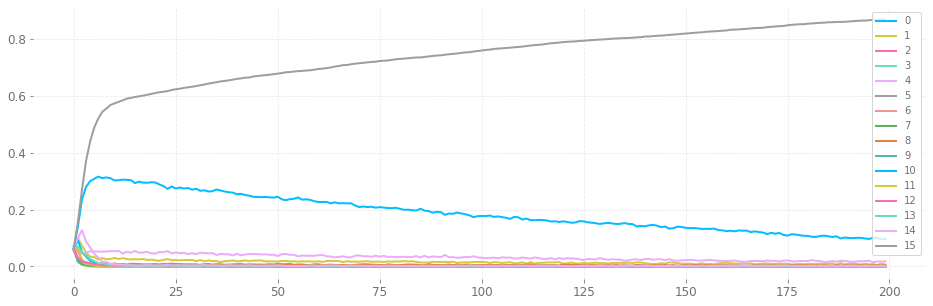

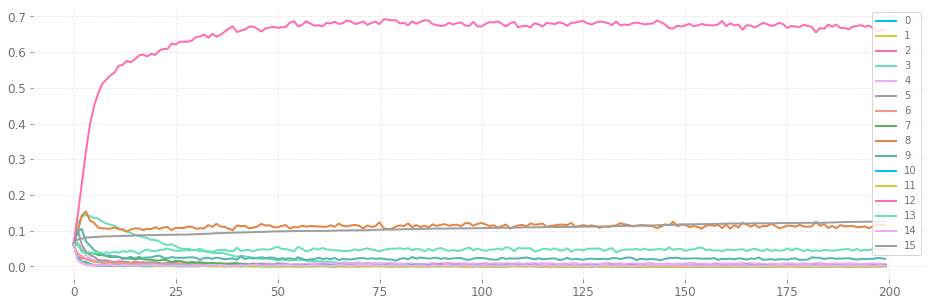

In [9]:
dist = np.array([np.bincount(states[:, i].astype(int)[labels==0], minlength=nStates) 
         for i in range(states.shape[1])])/sum(labels==0)
pd.DataFrame(dist).plot(figsize=(16,5))
dist = np.array([np.bincount(states[:, i].astype(int)[labels==1], minlength=nStates) 
         for i in range(states.shape[1])])/sum(labels==1)
pd.DataFrame(dist).plot(figsize=(16,5))

<AxesSubplot:>

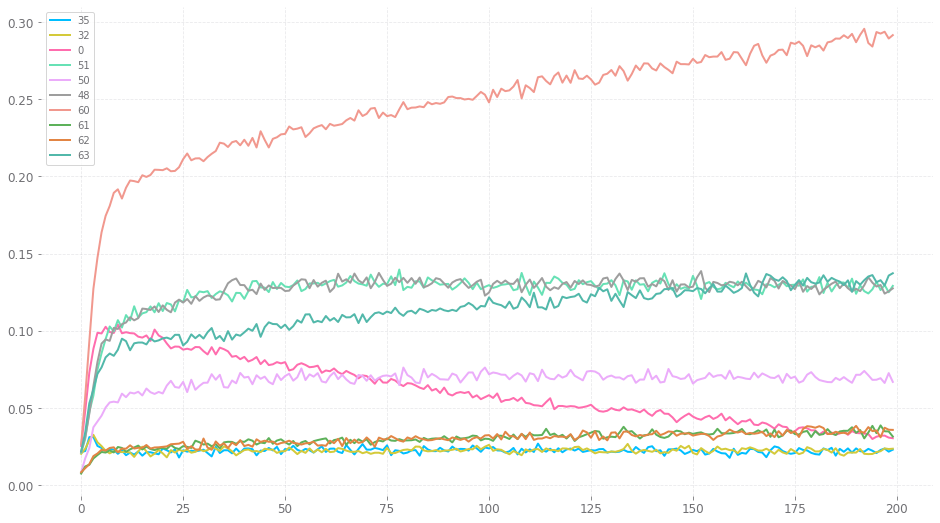

In [10]:
dist = np.array([np.bincount(stateactions[:, i].astype(int), minlength=nStates*nActions) 
         for i in range(stateactions.shape[1])])/len(labels)
pd.DataFrame(dist[:,np.argpartition(dist[-1,:], -10)[-10:]], 
            columns = np.argpartition(dist[-1,:], -10)[-10:]).plot(figsize=(16,9))
#pd.DataFrame(dist[:,[15,31,47,63]]/100000, 
#            columns = [15,31,47,63]).plot(figsize=(16,9))

And here's a plot of the L1-norm between distributions at step t and step t+1 over time. This converges really quickly to something in the neighborhood of 0.02. 

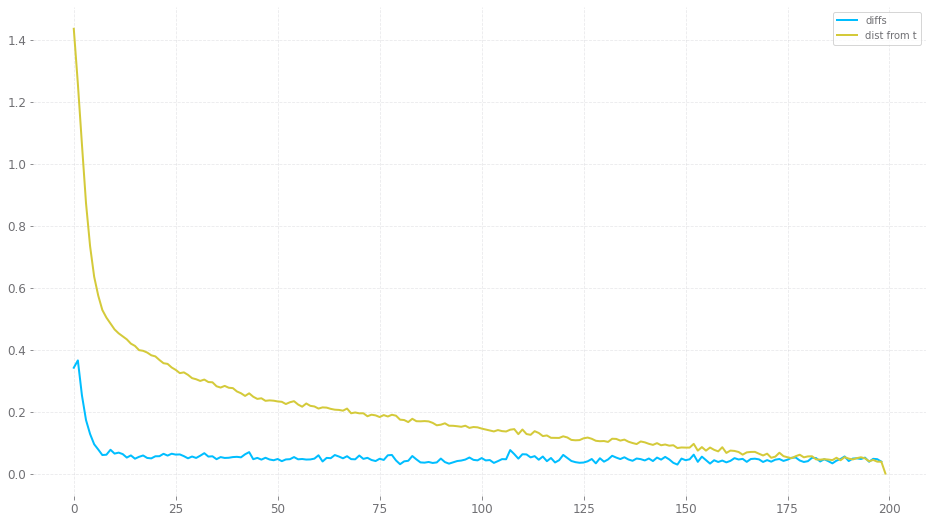

In [11]:
plt.figure(figsize=(16,9))
plt.plot(np.sum(np.abs(np.diff(dist, axis=0)),1), label='diffs')
plt.plot(np.sum(np.abs(dist - dist[-1]),1), label='dist from t')
plt.legend()

## Subspace Estimation

In [12]:
sadim = nStates*nActions
spdim = nStates
omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
onehotsa = np.eye(np.max(stateactions)+1)[stateactions]
onehotsaflat = copy.deepcopy(onehotsa)
onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
sz = int(onehotsa.shape[0]/3)

In [13]:
onehotsasub = onehotsa[:sz]
onehotsaflatsub = onehotsaflat[:sz]
onehotspsub = onehotsp[:sz]

onehotsaclust = onehotsa[sz:2*sz]
onehotsaflatclust = onehotsaflat[sz:2*sz]
onehotspclust = onehotsp[sz:2*sz]

onehotsaclass = onehotsa[2*sz:]
onehotsaflatclass = onehotsaflat[2*sz:]
onehotspclass = onehotsp[2*sz:]

In [14]:
np.array([i for i in range(64)]).reshape(nStates, nActions, order=memorder)
#so it turns out the s + a|S| ordering corresponds to Fortran ordering

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23],
       [24, 25, 26, 27],
       [28, 29, 30, 31],
       [32, 33, 34, 35],
       [36, 37, 38, 39],
       [40, 41, 42, 43],
       [44, 45, 46, 47],
       [48, 49, 50, 51],
       [52, 53, 54, 55],
       [56, 57, 58, 59],
       [60, 61, 62, 63]])

In [70]:
eigvalsa, eigvecsa = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, K, wt=True)

In [52]:
eigvalsp, eigvecsp = getEigKs(onehotsasub, onehotspsub, omegaone, omegatwo, K)

Finally, as a sanity check, we plot the absolute difference in eigenvalues on the log scale. We want this to always be nonzero, so if any entry is missing in the plot, then we'd be in trouble.

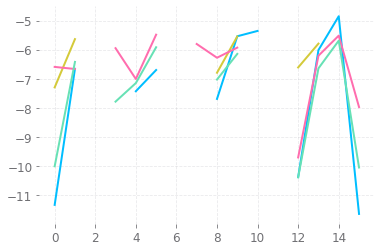

In [74]:
plt.plot(np.log(np.abs(eigvalsa[:,:,0] - eigvalsa[:,:,1])))

## Clustering

In [72]:
G = 3
omgones = np.array_split(omegaone,G)
omgtwos = np.array_split(omegatwo,G)
minlen = min([len(i) for i in omgones + omgtwos])
omgones = np.array([i[:minlen] for i in omgones])
omgtwos = np.array([i[:minlen] for i in omgtwos])

In [73]:
hs = geths(onehotsaclust, onehotspclust, omgones, omgtwos)
hs = hs[[g for g in range(G) if g % 2 == 0]].mean(0)

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.87it/s]


In [107]:
device = "/GPU:0"

statmns = computeStat(geth(onehotsaclust[:,omegaone,:,:], onehotspclust[:,omegaone,:]), 
                      geth(onehotsaclust[:,omegatwo,:,:], onehotspclust[:,omegatwo,:]), 
                      eigvecsa, device=device)
statmns2 = computeStatMeanOfMeans(hs, eigvecsa, device=device)



"\nd_sat = tf.convert_to_tensor(N_sa/N_sa.sum(), np.float64)\nstatmns2 = tfp.stats.percentile(\n                tf.reduce_max(\n                    tf.reduce_sum(\n                        (projst[:,0,None,...] - projst[:,0,:,None,...]) * \n                        (projst[:,1,None,...] - projst[:,1,:,None,...]), \n                    axis=-1), \n                axis=(3,4)), \n            axis=0, q=50.0, interpolation='midpoint').numpy()\n"

<AxesSubplot:ylabel='Density'>

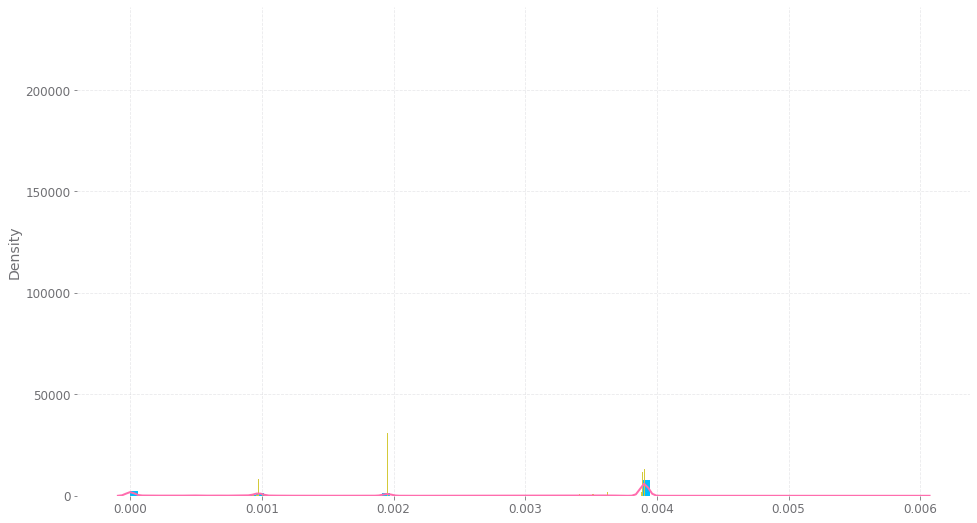

In [109]:
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns2.flatten(), bins=100, density=True)[2]
plt.hist(statmns2.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns2.flatten(), bw_adjust=0.5)

<AxesSubplot:ylabel='Density'>

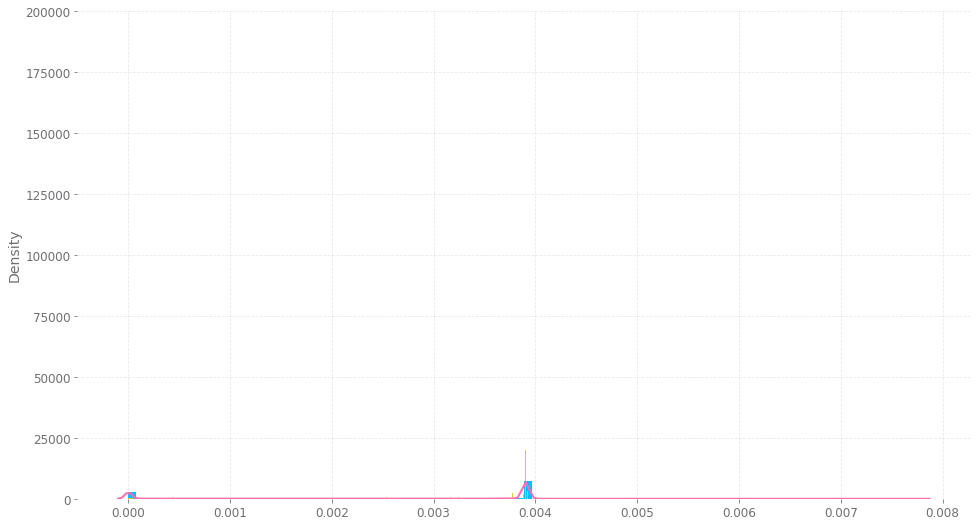

In [110]:
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=100, density=True)[2]
plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns.flatten(), bw_adjust=0.5)

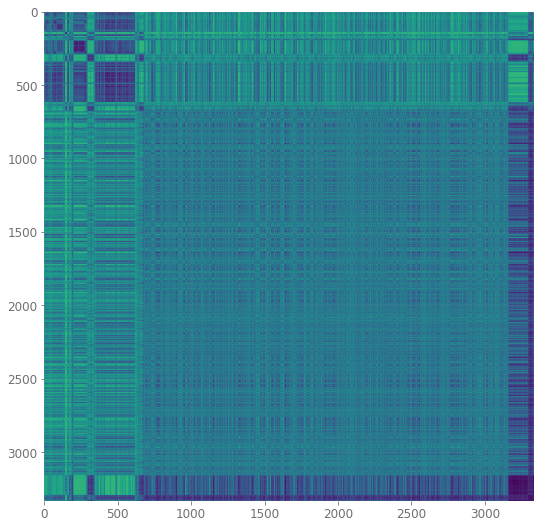

In [111]:
from scipy.cluster.hierarchy import linkage

m = 1-statmns2 #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

plt.figure(figsize=(16,9))
plt.imshow(1-m)

100%|███████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]


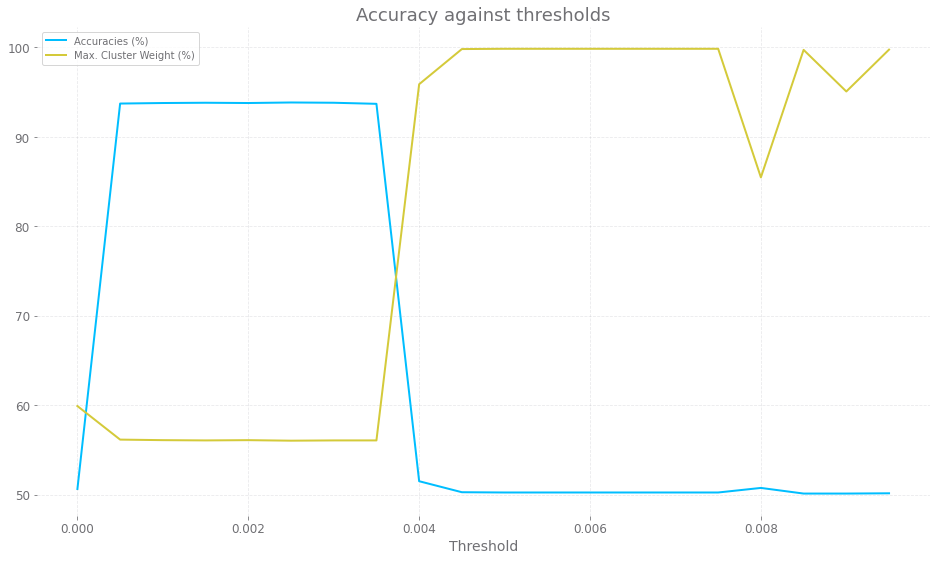

In [115]:
clusterDiagnostics(statmns, K=K, labels=confounders[sz:2*sz, 0],
                   lo=0, hi=0.01, step=0.0005)

100%|███████████████████████████████████████████| 20/20 [00:13<00:00,  1.48it/s]


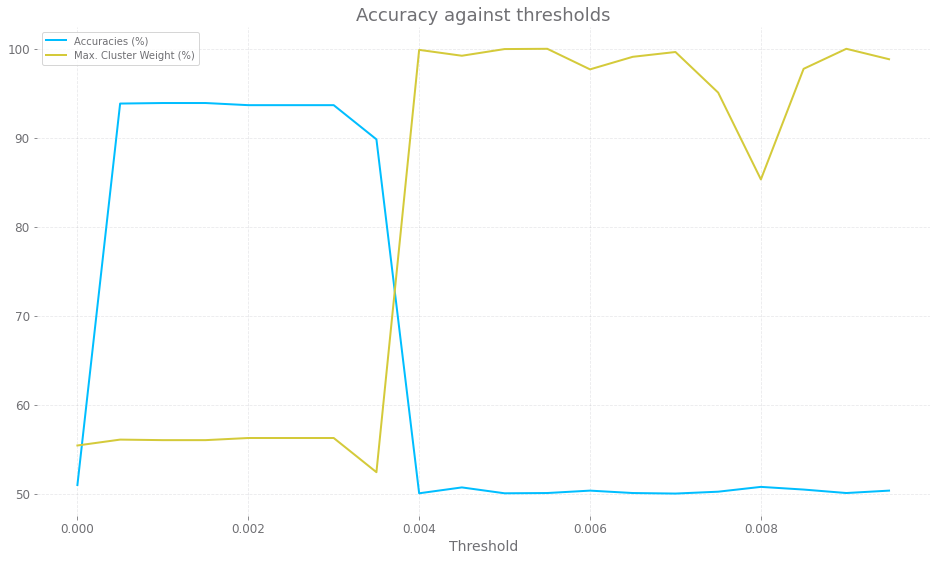

In [116]:
clusterDiagnostics(statmns2, K=K, labels=confounders[sz:2*sz, 0],
                   lo=0, hi=0.01, step=0.0005)

In [78]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, metric='precomputed').fit_transform(statmns2) #1-(statmns2 < 0.002)

Text(0.5, 0.98, 't-SNE Visualizations of Clusters and Confounders, Thresholded Distances')

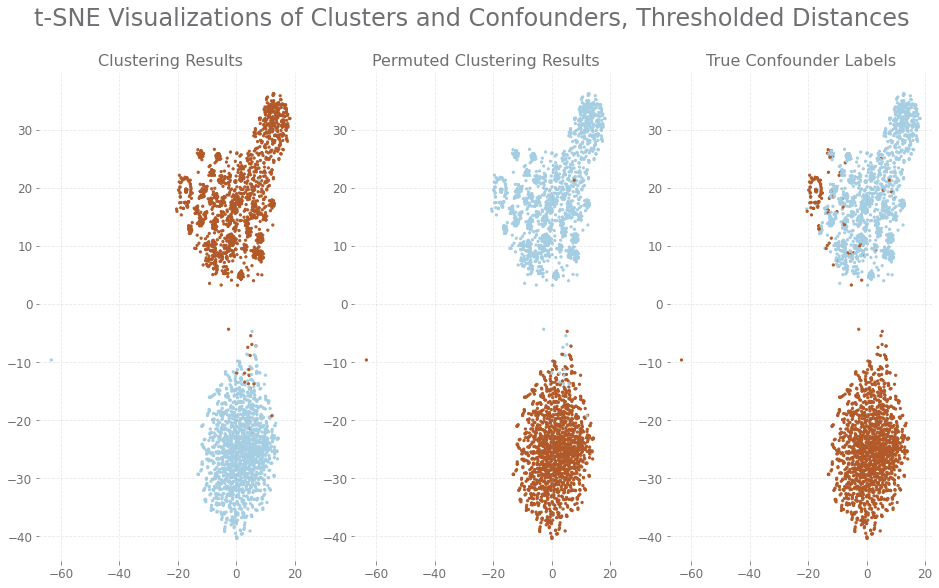

In [79]:
clusterlabs = sklearn.cluster.spectral_clustering((statmns2 < 0.002).astype(int), n_clusters=K,
                                                     assign_labels='kmeans')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

In [80]:
permutation = np.argmax([np.mean(clusterlabs == confounders[sz:2*sz, 0]), 
                    np.mean(clusterlabs != confounders[sz:2*sz, 0])])
print(permutation, np.max([np.mean(clusterlabs == confounders[sz:2*sz, 0]), 
                    np.mean(clusterlabs != confounders[sz:2*sz, 0])]))

1 0.9363936393639364


(array([1458.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1875.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

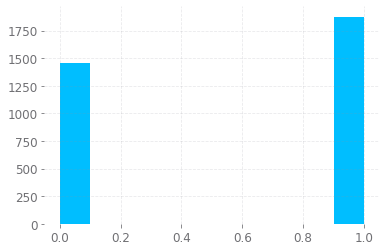

In [81]:
plt.hist(clusterlabs)

## Model Estimation

In [82]:
burnin = 10

In [117]:
@njit(parallel=False, fastmath=True)
def getmodelestim(clusterlabs, states, actions, nextstates,
                  K, nStates, nActions):
    Phat_ksa = np.zeros((K, nStates, nActions, nStates))
    for i in prange(states.shape[0]):
        for j in range(states.shape[1]):
            Phat_ksa[int(clusterlabs[i]), 
                     int(states[i,j]), 
                     int(actions[i,j]), 
                     int(nextstates[i,j])] += 1
    return Phat_ksa

@njit(parallel=False, fastmath=True)
def getmodelestimsoft(expect, states, actions, nextstates,
                  K, nStates, nActions):
    Phat_ksa = np.zeros((K, nStates, nActions, nStates))
    for i in prange(states.shape[0]):
        for j in range(states.shape[1]):
            for k in range(K):
                Phat_ksa[k, 
                         int(states[i,j]), 
                         int(actions[i,j]), 
                         int(nextstates[i,j])] += expect[k,i]
    return Phat_ksa

def getModelEstim(clusterlabs, states, actions, nextstates,
                  K, nStates, nActions, hard=True):
    if hard:
        model = getmodelestim(clusterlabs, states, actions, nextstates,
                  K, nStates, nActions)
        return model / model.sum(-1)[..., None]
    else:
        model = getmodelestimsoft(clusterlabs, states, actions, nextstates,
                  K, nStates, nActions)
        return model / np.nansum(model, axis=-1)[..., None]

Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                         states[sz:2*sz, burnin:], 
                         actions[sz:2*sz, burnin:], 
                         nextstates[sz:2*sz, burnin:],
                        K=K, nStates=nStates, nActions=nActions, hard=True)

## Classification

In [84]:
np.bincount(clusterlabs)/len(clusterlabs) 

array([0.43744374, 0.56255626])

In [118]:
#denoised model estimate
Phat_ksad = np.array([eigvecsa @ eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()
#projected models
projPhat = np.array([eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()

lam = 1
priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
#priorclass = np.array([0.5,0.5])
mleprobs = (np.log(Phat_ksa[:, states[2*sz:, burnin:], actions[2*sz:, burnin:], nextstates[2*sz:, burnin:]]).sum(-1))
mleprobs += np.random.uniform(high=1e-7, size=mleprobs.shape)
maxapos = (mleprobs + lam*np.log(priorclass)[:,None]).argmax(0)
mle = mleprobs.argmax(0)

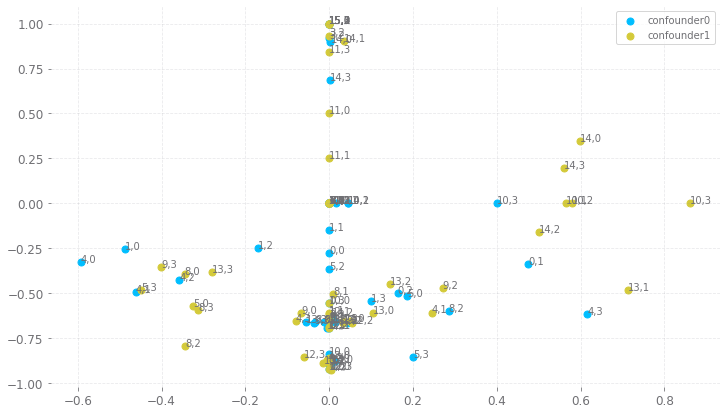

In [86]:
plt.figure(figsize=(12,7))
plt.scatter(projPhat.reshape(K, nStates*nActions, K)[0,:,0], projPhat.reshape(K, nStates*nActions, K)[0,:,1], label='confounder0')
plt.scatter(projPhat.reshape(K, nStates*nActions, K)[1,:,0], projPhat.reshape(K, nStates*nActions, K)[1,:,1], label='confounder1')
for s in range(nStates):
    for a in range(nActions):
        for k in range(K):
            plt.text(projPhat[k,s,a,0], projPhat[k,s,a,1], s=(str(s)+','+str(a)))
plt.legend()

In [87]:
np.mean(labels[2*sz:] == maxapos)
print('MAP estimate accuracy:', [np.mean(labels[2*sz:] == maxapos), np.mean(labels[2*sz:] != maxapos)][permutation])
print('MLE accuracy:', [np.mean(labels[2*sz:] == mle), np.mean(labels[2*sz:] != mle)][permutation])

MAP estimate accuracy: 0.9421115776844631
MLE accuracy: 0.8158368326334733


In [131]:
def getloglik(expect, modelestim, states, actions, nextstates, hard=True):
    if hard:
        return np.nansum(
                    np.nansum(
                        np.log(modelestim[:, states, actions, nextstates]), 
                    axis=-1)[expect, np.arange(len(states))])
    else:
        return np.nansum(
                    np.nansum(
                        np.log(np.nansum(modelestim[:, states, actions, nextstates] 
                                        * expect[...,None], axis=0)),
                    axis=-1))

def em(expect, modelestim, states, actions, nextstates, labels, 
                K=K, nStates=nStates, nActions=nActions, 
               max_iter = 100, checkin=5, 
               reg = 0, prior = priorclass, 
               permute=False, permutation=permutation, verbose=True, hard=True):
    i = 0
    modelold = np.ones(modelestim.shape)
    while i == 0 or np.nansum(np.abs(modelold - modelestim)) > 1e-3:
        modelold = modelestim
        
        if hard:
            modelestim = getModelEstim(expect.astype(int), states, actions, nextstates,
                                       K=K, nStates=nStates, nActions=nActions, hard=hard)
            expectprobs = np.log(modelestim[:, states, actions, nextstates]).sum(-1)
            expectprobs += np.random.uniform(high=1e-7, size=expectprobs.shape)
            expect = (expectprobs + #random number to perturb argmax 
                      reg*np.log(prior)[:,None]).argmax(0)
        else:
            modelestim = getModelEstim(expect, states, actions, nextstates,
                                       K=K, nStates=nStates, nActions=nActions, hard=hard)
            expectprobs = np.nansum(np.log(modelestim[:, states, actions, nextstates]), axis=-1)
            expectprobs += np.random.uniform(high=1e-7, size=expectprobs.shape)
            expect = np.exp(expectprobs + 
                            reg*np.log(prior)[:,None])
            expect = (expect / np.nansum(np.abs(expect), axis=0))
        
        i += 1
        if i % checkin == 0 and verbose:
            print('iteration', i, 'diff', np.nansum(np.abs(modelold - modelestim)))
            if permute:
                print('MLE accuracy:', max(np.mean(expect == labels), np.mean(expect != labels)))
            else:
                print('MLE accuracy:', [np.mean(expect == labels), np.mean(expect != labels)][permutation])
            print(getloglik(expect, modelestim, states, actions, nextstates, hard=hard))
        if i > max_iter:
            break
    loglik = getloglik(expect, modelestim, states, actions, nextstates, hard=hard)
    if verbose:
        print('log-likelihood:', loglik)
    return expect, modelestim, loglik

expectclass, modelestimclass, loglikclass = em(mle, 
                            Phat_ksa, states[2*sz:, burnin:], actions[2*sz:, burnin:], 
                        nextstates[2*sz:, burnin:], labels[2*sz:], 
                        reg = 0, prior = priorclass, permute=True, checkin=1, hard=True)

iteration 1 diff 19.277983459098117
MLE accuracy: 0.8179364127174565
-192391.1509384949
iteration 2 diff 9.686266472774951
MLE accuracy: 0.8302339532093581
-192199.09401007532
iteration 3 diff 1.2747727807422335
MLE accuracy: 0.8239352129574086
-192191.1779371918
iteration 4 diff 0.13018328352701347
MLE accuracy: 0.8269346130773845
-192190.890918146
iteration 5 diff 0.0
MLE accuracy: 0.8245350929814037
-192190.890918146
log-likelihood: -192190.890918146


In [132]:
expectclasssoft, modelestimclasssoft, loglikclasssoft = em((np.exp(mleprobs)/np.exp(mleprobs).sum(0)), 
                            Phat_ksa, states[2*sz:, burnin:], actions[2*sz:, burnin:], 
                        nextstates[2*sz:, burnin:], labels[2*sz:], 
                        reg = 0, prior = priorclass, permute=True, checkin=1, hard=False)

iteration 1 diff 2.009243443436497
MLE accuracy: 0.9991001799640072
-inf
iteration 2 diff 1.8514443036367796
MLE accuracy: 0.9991001799640072
-197079.2222448448
iteration 3 diff 8.381609091922389
MLE accuracy: 0.9991001799640072
-195499.42195572983
iteration 4 diff 16.937421593491997
MLE accuracy: 0.9989502099580084
-193608.00341920514
iteration 5 diff 15.5766075187029
MLE accuracy: 0.9979004199160167
-192677.83813181453
iteration 6 diff 11.301569860390968
MLE accuracy: 0.9302639472105579
-192123.02334347373
iteration 7 diff 9.602331447820701
MLE accuracy: 0.775494901019796
-191931.99730733345
iteration 8 diff 3.5123876477340907
MLE accuracy: 0.7736952609478105
-191913.43611673062
iteration 9 diff 1.1810245364092713
MLE accuracy: 0.7730953809238152
-191912.01143221633
iteration 10 diff 0.10427715122635343
MLE accuracy: 0.7730953809238152
-191911.977881007
iteration 11 diff 0.022699997822644234
MLE accuracy: 0.7730953809238152
-191911.9721505144
iteration 12 diff 0.006686391220640419
ML

## Refinement

In [91]:
catlabelsmap = np.concatenate([clusterlabs, maxapos]).astype(int)
catlabelsmle = np.concatenate([clusterlabs, mle]).astype(int)
catlabelsem = np.concatenate([clusterlabs, expectclass]).astype(int)
refinemap = getmodelestim(catlabelsmap, 
                       states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:])
refinemap /= refinemap.sum(-1)[..., None]
refinemle = getmodelestim(catlabelsmle, 
                       states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:])
refinemle /= refinemle.sum(-1)[..., None]
refineem = getmodelestim(catlabelsem, 
                       states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:])
refineem /= refineem.sum(-1)[..., None]

In [92]:
refinemleprobs = np.log(refinemle[:, states[sz:, burnin:], 
                                  actions[sz:, burnin:], 
                                  nextstates[sz:, burnin:]]).sum(-1) 
refinemleprobs += np.random.uniform(high=1e-7, size=refinemleprobs.shape)
refinemaplab = (refinemleprobs + 
                  lam*np.log(np.bincount(catlabelsmap)/len(catlabelsmap))[:,None]).argmax(0)
refinemlelab = (refinemleprobs).argmax(0)
refineemlab = (np.log(refineem[:, states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:]]).sum(-1)).argmax(0)

In [93]:
print('MAP estimate accuracy:', [np.mean(refinemaplab == labels[sz:]), np.mean(refinemaplab != labels[sz:])][permutation])
print('MLE accuracy:', [np.mean(refinemlelab == labels[sz:]), np.mean(refinemlelab != labels[sz:])][permutation])

MAP estimate accuracy: 0.9482525873706315
MLE accuracy: 0.8291585420728964


In [94]:
print('Hard EM Algorithm') 
expect, modelestim, loglikrefine = em(refineemlab, refineem, states[sz:, burnin:], 
                                      actions[sz:, burnin:], nextstates[sz:, burnin:], labels[sz:], reg=0.1, checkin=1)

Hard EM Algorithm
iteration 1 diff 7.633701952393245
MLE accuracy: 0.9511024448777561
-385202.60874730686
iteration 2 diff 2.566228217888529
MLE accuracy: 0.9512524373781311
-385182.2501587942
iteration 3 diff 0.12736652634052212
MLE accuracy: 0.9512524373781311
-385181.9625927676
iteration 4 diff 0.0
MLE accuracy: 0.9512524373781311
-385181.9625927676
log-likelihood: -385181.9625927676


In [95]:
print('Soft EM Algorithm')
expect, modelestim, loglikrefine = emsoft(np.exp(refinemleprobs)/np.exp(refinemleprobs).sum(0), refineem, states[sz:, burnin:], 
                                      actions[sz:, burnin:], nextstates[sz:, burnin:], labels[sz:], 
                                          reg=0.1, checkin=1)

Soft EM Algorithm
iteration 1 diff 5.837012138459747
MLE accuracy: 0.9506524673766311
-385171.68004982494
iteration 2 diff 3.3219176681430085
MLE accuracy: 0.9509524523773811
-385128.9160099247
iteration 3 diff 1.098515327583692
MLE accuracy: 0.9508024598770062
-385128.85178608017
iteration 4 diff 0.30072992234738144
MLE accuracy: 0.9508024598770062
-385128.97334995714
iteration 5 diff 0.0918474093594334
MLE accuracy: 0.9508024598770062
-385128.9839570997
iteration 6 diff 0.06699542592621616
MLE accuracy: 0.9508024598770062
-385128.96777967387
iteration 7 diff 0.07209523965093763
MLE accuracy: 0.9509524523773811
-385128.9439631754
iteration 8 diff 0.09078338837043386
MLE accuracy: 0.9509524523773811
-385128.951129946
iteration 9 diff 0.12391708915174748
MLE accuracy: 0.9509524523773811
-385129.09731264017
iteration 10 diff 0.16112819967618996
MLE accuracy: 0.9509524523773811
-385129.3442791538
iteration 11 diff 0.13819811573252938
MLE accuracy: 0.9509524523773811
-385129.2704717169
ite

## Stable Baselines: EM Algorithm Alone

In [96]:
randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
randmodel = getmodelestim(randlabs, states[:, burnin:], actions[:, burnin:], nextstates[:, burnin:])
randlabs, randmodel, loglikrand = em(randlabs, randmodel,
   states[:, burnin:], actions[:, burnin:], nextstates[:, burnin:], labels, reg=0, permute=True, checkin=5)

iteration 5 diff 19.63315834853276
MLE accuracy: 0.8181
-579599.9809387256
log-likelihood: -579261.1069935015


In [97]:
unifs = np.random.uniform(size=len(dataset))
randlabsoft = np.vstack([unifs, 1-unifs])
randmodelsoft = getmodelestimsoft(randlabsoft, states[:, burnin:], actions[:, burnin:], nextstates[:, burnin:])
randlabs, randmodel, loglikrand = emsoft(randlabsoft, randmodelsoft,
   states[:, burnin:], actions[:, burnin:], nextstates[:, burnin:], labels, reg=0, permute=True, checkin=5, verbose=True)

iteration 5 diff 1.8855261937855365
MLE accuracy: 0.693
-593030.5050098621
iteration 10 diff 9.358743866815704
MLE accuracy: 0.8306
-577048.1542505658
iteration 15 diff 0.14561955453852118
MLE accuracy: 0.8308
-576914.5793481157
iteration 20 diff 0.13811680688762568
MLE accuracy: 0.8214
-576914.391997032
iteration 25 diff 0.2404423738014422
MLE accuracy: 0.831
-576914.8133574347
iteration 30 diff 0.09630233773316269
MLE accuracy: 0.8314
-576915.0400629886
iteration 35 diff 0.03579075095781201
MLE accuracy: 0.8351
-576914.4794893367
iteration 40 diff 0.028983316290303048
MLE accuracy: 0.8355
-576914.0900688625
iteration 45 diff 0.038038074533991
MLE accuracy: 0.8299
-576913.7291195802
iteration 50 diff 0.08263780048390762
MLE accuracy: 0.828
-576913.2249786641
iteration 55 diff 0.3453598898837441
MLE accuracy: 0.831
-576913.7405127893
iteration 60 diff 0.016360956051901264
MLE accuracy: 0.8335
-576915.2218151377
iteration 65 diff 0.0018148706492594126
MLE accuracy: 0.8333
-576915.275288

In [88]:
labelsemsoft = []
logliksemsoft = []
for i in tqdm(range(30)):
    unifs = np.random.uniform(size=len(dataset[sz:]))
    randlabsoft = np.vstack([unifs, 1-unifs])
    randmodelsoft = getmodelestimsoft(randlabsoft, states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:])
    randlabsoft, randmodelsoft, loglikrand = emsoft(randlabsoft, randmodelsoft,
       states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:], labels, reg=1e-5, permute=True, checkin=5, verbose=False)
    labelsemsoft.append(randlabsoft)
    logliksemsoft.append(loglikrand)

100%|███████████████████████████████████████████| 30/30 [00:37<00:00,  1.24s/it]


In [89]:
labelsem = []
logliksem = []
for i in tqdm(range(30)):
    randlabs = np.random.binomial(1, 0.5, size=len(dataset[sz:])).astype(int)
    randmodel = getmodelestim(randlabs, states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:])
    randlabs, randmodel, loglikrand = em(randlabs, randmodel,
       states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:], labels, reg=1e-5, permute=True, verbose=False)
    labelsem.append(randlabs)
    logliksem.append(loglikrand)

100%|███████████████████████████████████████████| 30/30 [00:14<00:00,  2.01it/s]


In [106]:
np.array([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in labelsem])[np.argpartition(logliksem, 50)[-50:]].mean()

0.8188480575971201

Text(0.5, 1.0, 'Randomly Initialized Hard EM Algorithm')

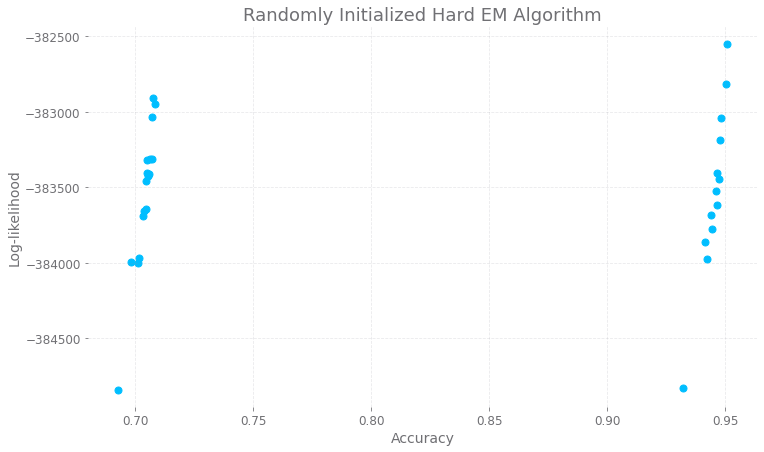

In [93]:
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in labelsem], logliksem)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Hard EM Algorithm')

Text(0.5, 1.0, 'Randomly Initialized Soft EM Algorithm')

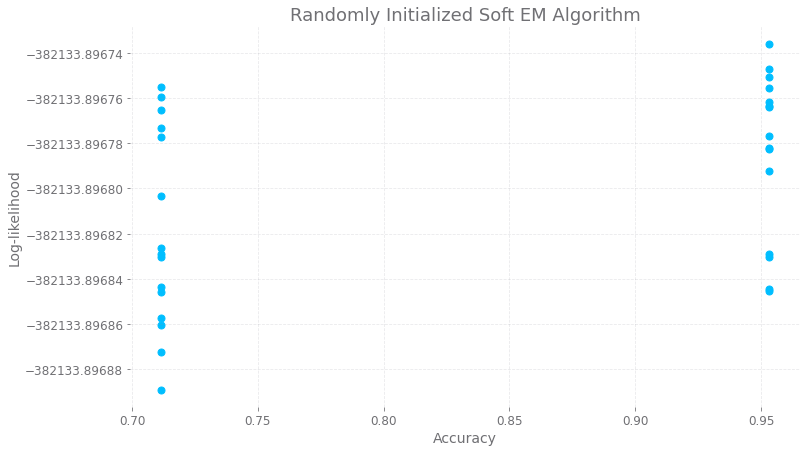

In [92]:
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')

(array([15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15.]),
 array([0.71141443, 0.73560822, 0.75980201, 0.7839958 , 0.80818959,
        0.83238338, 0.85657717, 0.88077096, 0.90496475, 0.92915854,
        0.95335233]),
 <BarContainer object of 10 artists>)

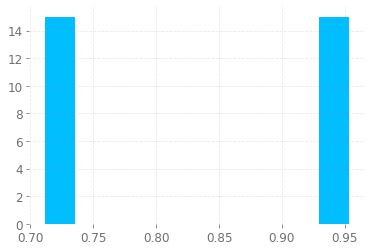

In [94]:
plt.hist([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in np.array(labelsemsoft).argmax(axis=1)])

(array([17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.]),
 array([0.69266537, 0.71847908, 0.74429279, 0.77010649, 0.7959202 ,
        0.82173391, 0.84754762, 0.87336133, 0.89917504, 0.92498875,
        0.95080246]),
 <BarContainer object of 10 artists>)

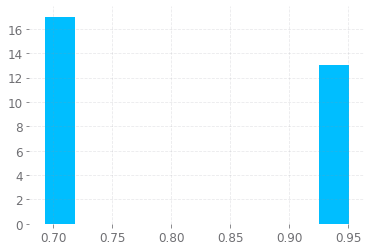

In [95]:
plt.hist([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in labelsem])

## Stable Baselines: Occupancy Counts Past Mixing Time

In [96]:
onehots = onehotsaclust[:, omegatwo,...].sum(1)
statbase = np.abs(onehots[None,...] - onehots[:,None,...]).sum(axis=(2,3))
tsnebase = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, 
                                 metric='precomputed').fit_transform(statbase)
clusterlabs = sklearn.cluster.spectral_clustering((statbase.max() - statbase), n_clusters=K,
                                                     assign_labels='kmeans')
max(np.mean(clusterlabs == labels[sz:2*sz]), np.mean(clusterlabs != labels[sz:2*sz]))

0.8700870087008701

Text(0.5, 0.98, 't-SNE Visualizations of Clusters and Confounders, Thresholded Distances')

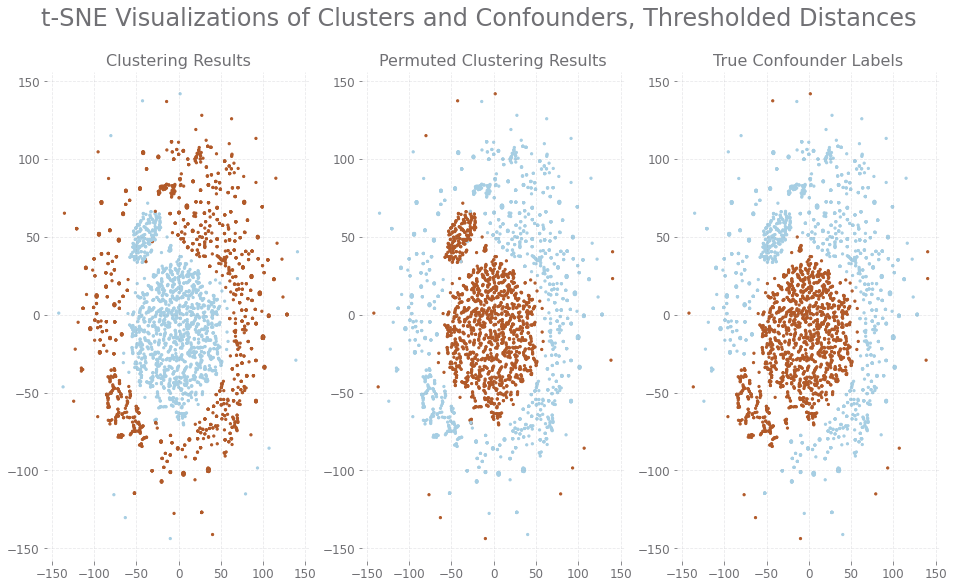

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsnebase[:,0], tsnebase[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsnebase[:,0], tsnebase[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsnebase[:,0], tsnebase[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

## MLE vs MAP

Text(0.5, 0.98, 't-SNE Visualizations of Post-Refinement MLE and Confounders, Thresholded Distances')

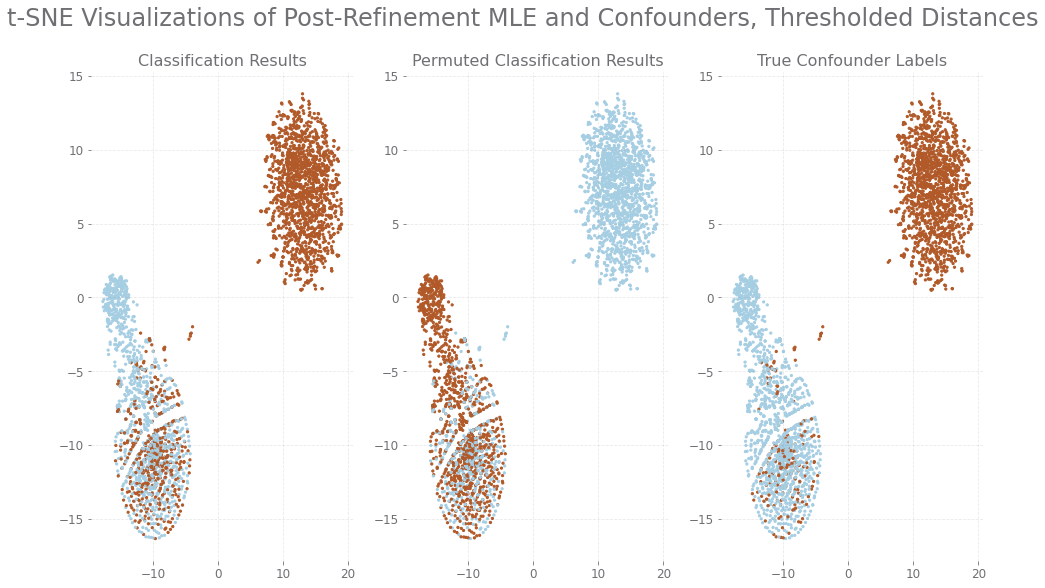

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=refinemlelab[:sz], cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-refinemlelab[:sz], cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Classification Results', fontsize=16)
axes[1].set_title('Permuted Classification Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Post-Refinement MLE and Confounders, Thresholded Distances', fontsize=24)

Text(0.5, 0.98, 't-SNE Visualizations of Post-Refinement MAP Labels and Confounders, Thresholded Distances')

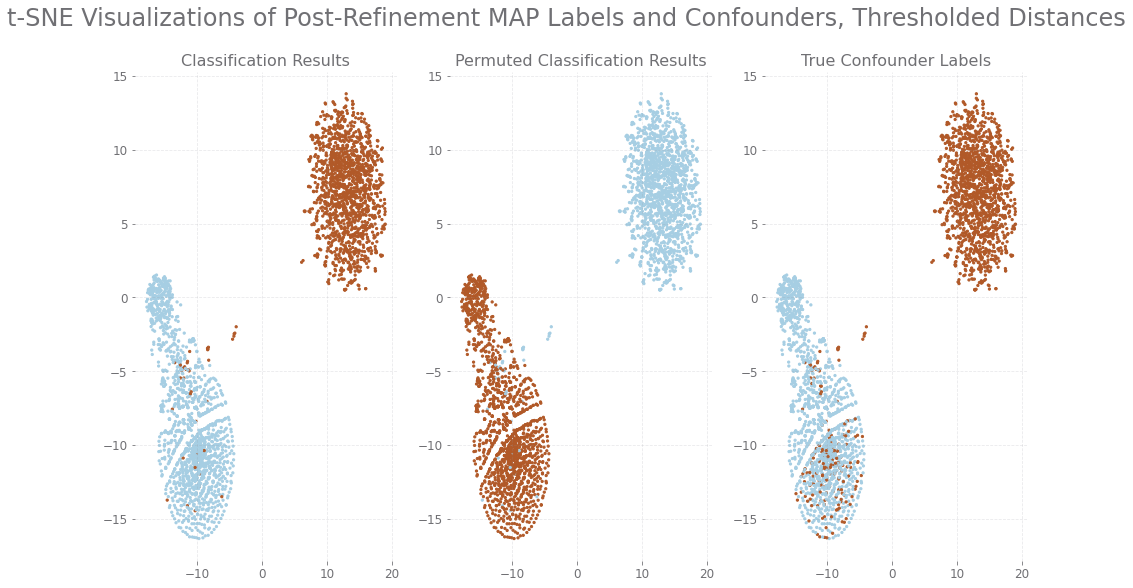

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=refinemaplab[:sz], cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-refinemaplab[:sz], cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Classification Results', fontsize=16)
axes[1].set_title('Permuted Classification Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Post-Refinement MAP Labels and Confounders, Thresholded Distances', fontsize=24)